In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "TCP"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn004651,MEVEEIQNQGCKFPRISNGRGDLTKIGQKGEDQYQEDEKDGEVKRG...,420,1
1,Achn033791,MYPFNTNGNLISYTLYNPNSKQDHPPPPSSLSYFPSPPYIPYEDDD...,404,1
2,Achn033961,MYPSNTNGNLISYTLYDYDLNNANSKQDYHPPIPPPLSSISYFPSP...,322,1
3,Achn039311,MSITENNNNNNKNKPQEIKDLQIVIADKEEASKKQLAPKRSSNKDR...,249,1
4,Achn039821,MYPSSNNDNTPITYPSLDQTICFKSSLYDDFTSNSTQDQDPQSSSL...,324,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
6030,0.004866,0.002433,0.007299,0.002433,0.002433,0.004866,0.000000,0.004866,0.002433,0.004866,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.002433,0.0,0.0,0.000000
139,0.008889,0.000000,0.004444,0.008889,0.000000,0.000000,0.000000,0.004444,0.000000,0.000000,...,0.013333,0.000000,0.000000,0.004444,0.0,0.004444,0.004444,0.0,0.0,0.004444
3983,0.019093,0.000000,0.004773,0.007160,0.000000,0.009547,0.002387,0.002387,0.002387,0.007160,...,0.000000,0.000000,0.000000,0.002387,0.0,0.000000,0.000000,0.0,0.0,0.000000
4488,0.015198,0.003040,0.003040,0.012158,0.006079,0.003040,0.000000,0.009119,0.003040,0.012158,...,0.000000,0.006079,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000
5556,0.003268,0.003268,0.003268,0.006536,0.003268,0.000000,0.003268,0.000000,0.009804,0.003268,...,0.000000,0.000000,0.003268,0.003268,0.0,0.000000,0.000000,0.0,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (6676, 441)
X_test: (1669, 441)
y_train: (6676,)
y_test: (1669,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 52s 631ms/step - accuracy: 0.4062 - loss: 0.6935

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5960 - loss: 0.6878   

55/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6794 - loss: 0.6589

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7297 - loss: 0.6016

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7325 - loss: 0.5976 - val_accuracy: 0.9506 - val_loss: 0.1263


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0511

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9666 - loss: 0.1082 

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9699 - loss: 0.1002

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9719 - loss: 0.0945

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9725 - loss: 0.0927 - val_accuracy: 0.9828 - val_loss: 0.0639


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9531 - loss: 0.1328

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9823 - loss: 0.0529 

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9846 - loss: 0.0494

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9850 - loss: 0.0484

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9851 - loss: 0.0484 - val_accuracy: 0.9828 - val_loss: 0.0525


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0101

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9898 - loss: 0.0373 

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0395

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0401

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9880 - loss: 0.0401 - val_accuracy: 0.9835 - val_loss: 0.0443


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0053

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9908 - loss: 0.0299 

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9885 - loss: 0.0351

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9877 - loss: 0.0364

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0367 - val_accuracy: 0.9843 - val_loss: 0.0479


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0040

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0191 

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0198

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0212

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0217 - val_accuracy: 0.9835 - val_loss: 0.0502


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0065

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0120 

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0142

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0154

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9950 - loss: 0.0158 - val_accuracy: 0.9805 - val_loss: 0.0633


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0181

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9915 - loss: 0.0209 

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0213

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0210

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0209 - val_accuracy: 0.9865 - val_loss: 0.0367


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0826

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0263 

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9928 - loss: 0.0274

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0269

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0263 - val_accuracy: 0.9880 - val_loss: 0.0431


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0016

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0105 

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0124

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0134

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0138 - val_accuracy: 0.9865 - val_loss: 0.0428


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0057

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0154 

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0145

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0140

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0138 - val_accuracy: 0.9880 - val_loss: 0.0415


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0057

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0063 

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0112

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9955 - loss: 0.0139

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0143 - val_accuracy: 0.9805 - val_loss: 0.0715


Epoch 13/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0313

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0235 

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0193

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0168

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0163 - val_accuracy: 0.9858 - val_loss: 0.0512


Epoch 14/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0096

27/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0172 

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0158

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0146

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0143 - val_accuracy: 0.9828 - val_loss: 0.0650


Epoch 15/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0017

24/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0022 

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - loss: 0.0044

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0060

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0063 - val_accuracy: 0.9888 - val_loss: 0.0496


Epoch 16/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0016

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0052 

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0063

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0106

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0116 - val_accuracy: 0.9880 - val_loss: 0.0408


Epoch 17/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0274

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0177 

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0166

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0169

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9933 - loss: 0.0168 - val_accuracy: 0.9888 - val_loss: 0.0431


Epoch 18/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0025

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0135 

49/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0117

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0108

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0108 - val_accuracy: 0.9895 - val_loss: 0.0446


Epoch 19/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0011

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0103 

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0097

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0090

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0089 - val_accuracy: 0.9888 - val_loss: 0.0498


Epoch 20/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 9.9740e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0022     

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0018

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0034

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0042 - val_accuracy: 0.9888 - val_loss: 0.0425


Epoch 21/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0016

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0268 

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0201

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0165

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9960 - loss: 0.0159 - val_accuracy: 0.9798 - val_loss: 0.0787


Epoch 22/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0020

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9852 - loss: 0.0457 

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0406

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9882 - loss: 0.0356

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0344 - val_accuracy: 0.9775 - val_loss: 0.0770


Epoch 23/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.0779

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0259 

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9954 - loss: 0.0191

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9961 - loss: 0.0165

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0159 - val_accuracy: 0.9895 - val_loss: 0.0482


Epoch 24/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 8.5630e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0086     

48/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0088

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0083

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0081 - val_accuracy: 0.9873 - val_loss: 0.0628


Epoch 25/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 6.1646e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0083     

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0085

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0080

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0081 - val_accuracy: 0.9888 - val_loss: 0.0489


Epoch 26/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0020

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0101 

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0080

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9980 - loss: 0.0071

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0070 - val_accuracy: 0.9543 - val_loss: 0.1995


Epoch 27/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0141

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9645 - loss: 0.1230 

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9744 - loss: 0.0889

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9794 - loss: 0.0720

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9806 - loss: 0.0681 - val_accuracy: 0.9850 - val_loss: 0.0594


Epoch 28/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0033

26/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0105 

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0096

76/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0095

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0095 - val_accuracy: 0.9895 - val_loss: 0.0453



[Train Accuracy: 99.70% - Test Accuracy: 98.74%]


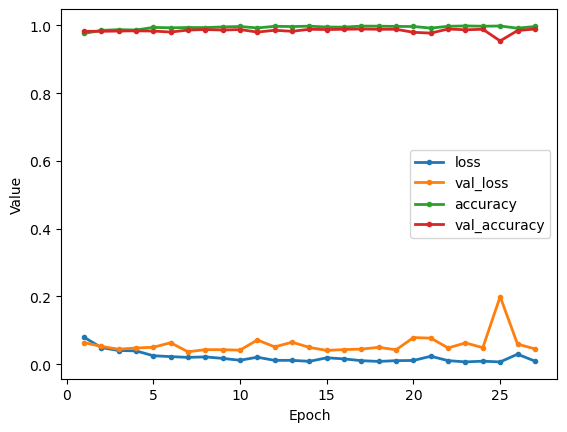

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/53 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step


 1/53 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
6030,0.000000,0.0,0.002439,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.004464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3983,0.004785,0.0,0.000000,0.002392,0.0,0.002392,0.002392,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488,0.000000,0.0,0.000000,0.003049,0.0,0.000000,0.000000,0.006098,0.000000,0.003049,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5556,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.003279,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (6676, 8875)
X_test: (1669, 8875)
y_train: (6676,)
y_test: (1669,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,272,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,315,521 (8.83 MB)

 Trainable params: 2,315,521 (8.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 53s 643ms/step - accuracy: 0.6094 - loss: 0.6931

 8/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5435 - loss: 0.6928   

15/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5554 - loss: 0.6919

23/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5931 - loss: 0.6894

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6255 - loss: 0.6854

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6533 - loss: 0.6791

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6770 - loss: 0.6694

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6977 - loss: 0.6564

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7158 - loss: 0.6404

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7316 - loss: 0.6227

72/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7456 - loss: 0.6043

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7580 - loss: 0.5861

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7675 - loss: 0.5710 - val_accuracy: 0.9940 - val_loss: 0.0252


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0100

 8/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9973 - loss: 0.0188 

15/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0216

22/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9965 - loss: 0.0215

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9965 - loss: 0.0213

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0213

45/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0213

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9963 - loss: 0.0212

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0210

67/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0207

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0204

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9964 - loss: 0.0202

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9964 - loss: 0.0202 - val_accuracy: 0.9985 - val_loss: 0.0139


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0094

 8/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0102 

15/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0086

22/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9999 - loss: 0.0078

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9997 - loss: 0.0072

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0068

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0066

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0064

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0062

64/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0061

71/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0061

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0060

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9992 - loss: 0.0059 - val_accuracy: 0.9970 - val_loss: 0.0126


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 0.0017

 8/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0023 

15/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0029

22/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0033

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0032

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0032

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0031

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0030

57/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0030

64/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0030

71/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0029

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0029

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9991 - loss: 0.0030 - val_accuracy: 0.9970 - val_loss: 0.0109


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 5.0512e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.0162e-04 

15/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9998 - loss: 0.0017    

22/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0024

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9994 - loss: 0.0028

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0029

43/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0030

50/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0030

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0029

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0029

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0028

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0027

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.9970 - val_loss: 0.0126


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 3.6968e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9553e-04 

17/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.9211e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.8972e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7137e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4912e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2756e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0643e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8664e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.9276e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.1993e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1422e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 7.5735e-04 - val_accuracy: 0.9985 - val_loss: 0.0114


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 2.0109e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6393e-04 

15/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.7373e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4884e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4228e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2869e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1158e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9647e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8109e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6908e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5643e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4701e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 3.4192e-04 - val_accuracy: 0.9970 - val_loss: 0.0139


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 1.0000 - loss: 1.0450e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6612e-04 

16/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5608e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4688e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3867e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3422e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2992e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2765e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2506e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2290e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2097e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 1.1933e-04 - val_accuracy: 0.9970 - val_loss: 0.0142


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 7.0490e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1130e-04 

16/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0115e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7855e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.3938e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.0977e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8890e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7208e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6404e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6372e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5924e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.5163e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 8.4780e-05 - val_accuracy: 0.9970 - val_loss: 0.0135


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 3.6834e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3664e-05 

16/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9862e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.3092e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2900e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1693e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0371e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9091e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0339e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.2631e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4414e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.6035e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 7.6356e-05 - val_accuracy: 0.9970 - val_loss: 0.0124


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.7332e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1909e-05 

15/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.5217e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7625e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7452e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6673e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.5717e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4617e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.3591e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2548e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1778e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1181e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 5.0944e-05 - val_accuracy: 0.9970 - val_loss: 0.0163


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 2.2387e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2469e-04 

15/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9940e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6360e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3794e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1726e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9521e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7685e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6082e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4827e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3697e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2696e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.0000 - loss: 2.2176e-04 - val_accuracy: 0.9970 - val_loss: 0.0135



[Train Accuracy: 100.00% - Test Accuracy: 99.82%]


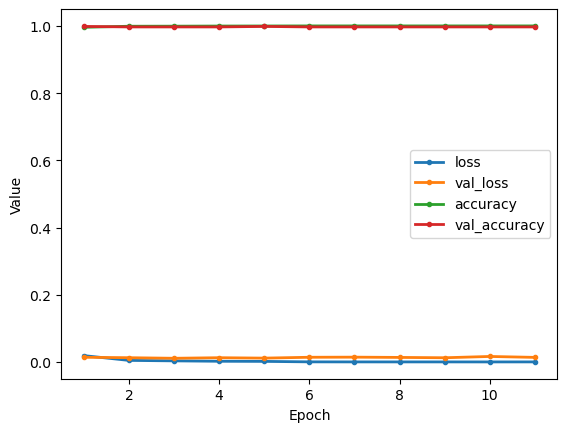

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/53 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

40/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/53 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

41/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
6030,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
139,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3983,0.002398,0.0,0.0,0.0,0.0,0.002398,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4488,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5556,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      38,345,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,387,201 (146.44 MB)

 Trainable params: 38,387,201 (146.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1:11 858ms/step - accuracy: 0.5469 - loss: 0.6931

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - accuracy: 0.5273 - loss: 0.6932 

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.5200 - loss: 0.6932

 4/84 ━━━━━━━━━━━━━━━━━━━━ 10s 132ms/step - accuracy: 0.5160 - loss: 0.6932

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5103 - loss: 0.6932

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5107 - loss: 0.6931

 7/84 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5137 - loss: 0.6931

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.5200 - loss: 0.6930

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.5268 - loss: 0.6930

10/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.5326 - loss: 0.6929 

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.5378 - loss: 0.6928

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.5431 - loss: 0.6927

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.5495 - loss: 0.6926

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 134ms/step - accuracy: 0.5566 - loss: 0.6925

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.5642 - loss: 0.6924

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step - accuracy: 0.5719 - loss: 0.6922

17/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5796 - loss: 0.6921

18/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5871 - loss: 0.6919

19/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5945 - loss: 0.6917

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6017 - loss: 0.6915

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.6083 - loss: 0.6913

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6145 - loss: 0.6911

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.6205 - loss: 0.6909

24/84 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6265 - loss: 0.6906

25/84 ━━━━━━━━━━━━━━━━━━━━ 7s 133ms/step - accuracy: 0.6323 - loss: 0.6904

26/84 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6380 - loss: 0.6901

27/84 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6435 - loss: 0.6897

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6489 - loss: 0.6894

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6541 - loss: 0.6890

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6591 - loss: 0.6886

31/84 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6639 - loss: 0.6882

32/84 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6685 - loss: 0.6877

33/84 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6730 - loss: 0.6872

34/84 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6772 - loss: 0.6867

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6813 - loss: 0.6861

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6853 - loss: 0.6855

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6893 - loss: 0.6848

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.6931 - loss: 0.6841

39/84 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.6968 - loss: 0.6834

40/84 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7004 - loss: 0.6826

41/84 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7039 - loss: 0.6818

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7073 - loss: 0.6809

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7106 - loss: 0.6799

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7138 - loss: 0.6789

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7169 - loss: 0.6778

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.7200 - loss: 0.6767

47/84 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7230 - loss: 0.6755

48/84 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7259 - loss: 0.6743

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7288 - loss: 0.6730

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7316 - loss: 0.6716

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7343 - loss: 0.6701

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.7370 - loss: 0.6687

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 0.7396 - loss: 0.6671

54/84 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7421 - loss: 0.6655

55/84 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.7445 - loss: 0.6639

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7470 - loss: 0.6621

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7493 - loss: 0.6604

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7516 - loss: 0.6586

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7539 - loss: 0.6567

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7561 - loss: 0.6547

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.7583 - loss: 0.6528

62/84 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7604 - loss: 0.6507

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7625 - loss: 0.6487

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7645 - loss: 0.6466

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.7665 - loss: 0.6444

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7685 - loss: 0.6423

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.7704 - loss: 0.6401

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.7723 - loss: 0.6379

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.7741 - loss: 0.6356

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7759 - loss: 0.6334

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7777 - loss: 0.6311

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7795 - loss: 0.6288

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7812 - loss: 0.6265

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7829 - loss: 0.6242

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7845 - loss: 0.6219

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.7861 - loss: 0.6196

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7878 - loss: 0.6172

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7893 - loss: 0.6149

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7909 - loss: 0.6125

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7924 - loss: 0.6102

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7939 - loss: 0.6078

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7953 - loss: 0.6055

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7968 - loss: 0.6031

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7982 - loss: 0.6008

84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 171ms/step - accuracy: 0.7996 - loss: 0.5985 - val_accuracy: 0.9948 - val_loss: 0.0239


Epoch 2/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 18s 220ms/step - accuracy: 1.0000 - loss: 0.0195

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 0.0170

 3/84 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 1.0000 - loss: 0.0157

 4/84 ━━━━━━━━━━━━━━━━━━━━ 12s 158ms/step - accuracy: 1.0000 - loss: 0.0150

 5/84 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - accuracy: 1.0000 - loss: 0.0145

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 1.0000 - loss: 0.0140

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.9997 - loss: 0.0138

 8/84 ━━━━━━━━━━━━━━━━━━━━ 11s 153ms/step - accuracy: 0.9995 - loss: 0.0136

 9/84 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9991 - loss: 0.0140

10/84 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9989 - loss: 0.0143

11/84 ━━━━━━━━━━━━━━━━━━━━ 11s 154ms/step - accuracy: 0.9988 - loss: 0.0145

12/84 ━━━━━━━━━━━━━━━━━━━━ 11s 156ms/step - accuracy: 0.9986 - loss: 0.0145

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9985 - loss: 0.0147

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9983 - loss: 0.0148

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - accuracy: 0.9982 - loss: 0.0152

16/84 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9980 - loss: 0.0156

17/84 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9978 - loss: 0.0159

18/84 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.9977 - loss: 0.0162

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9975 - loss: 0.0164 

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9974 - loss: 0.0166

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9973 - loss: 0.0168

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.9972 - loss: 0.0170

23/84 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.9971 - loss: 0.0171

24/84 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.9970 - loss: 0.0172

25/84 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.9970 - loss: 0.0174

26/84 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.9969 - loss: 0.0174

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.9968 - loss: 0.0175

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9968 - loss: 0.0176

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9967 - loss: 0.0177

30/84 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9967 - loss: 0.0177

31/84 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9967 - loss: 0.0177

32/84 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - accuracy: 0.9967 - loss: 0.0177

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9967 - loss: 0.0177

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9966 - loss: 0.0177

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9966 - loss: 0.0177

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.9966 - loss: 0.0177

37/84 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.9966 - loss: 0.0176

38/84 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - accuracy: 0.9966 - loss: 0.0176

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9966 - loss: 0.0175

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9966 - loss: 0.0175

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9966 - loss: 0.0174

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.9966 - loss: 0.0174

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9966 - loss: 0.0174

44/84 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9966 - loss: 0.0173

45/84 ━━━━━━━━━━━━━━━━━━━━ 6s 155ms/step - accuracy: 0.9966 - loss: 0.0173

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9966 - loss: 0.0172

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9966 - loss: 0.0172

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9966 - loss: 0.0171

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9966 - loss: 0.0171

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9966 - loss: 0.0170

51/84 ━━━━━━━━━━━━━━━━━━━━ 5s 155ms/step - accuracy: 0.9966 - loss: 0.0170

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 0.9966 - loss: 0.0169

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9966 - loss: 0.0169

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9967 - loss: 0.0168

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9967 - loss: 0.0168

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9967 - loss: 0.0167

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9967 - loss: 0.0167

58/84 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.9967 - loss: 0.0166

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9967 - loss: 0.0166

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9967 - loss: 0.0165

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9967 - loss: 0.0164

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9967 - loss: 0.0164

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9968 - loss: 0.0163

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9968 - loss: 0.0163

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0162

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0161

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0161

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0160

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0159

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.9968 - loss: 0.0159

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9969 - loss: 0.0158

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9969 - loss: 0.0158

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9969 - loss: 0.0157

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9969 - loss: 0.0156

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9969 - loss: 0.0156

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9969 - loss: 0.0155

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.9969 - loss: 0.0154

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9970 - loss: 0.0154

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9970 - loss: 0.0153

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9970 - loss: 0.0153

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.9970 - loss: 0.0152

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9970 - loss: 0.0151

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9970 - loss: 0.0151

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.9970 - loss: 0.0150

84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 166ms/step - accuracy: 0.9970 - loss: 0.0150 - val_accuracy: 0.9955 - val_loss: 0.0100


Epoch 3/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 16s 204ms/step - accuracy: 1.0000 - loss: 9.7956e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 9.7201e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 9.8818e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 0.0010    

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 0.0010

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 0.0010

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 0.0010

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 0.0010

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 0.0010

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 0.0010

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 0.0010

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 0.0010

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 0.0010

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 0.0010

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 0.0010

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 0.0010 

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 0.0010

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 0.0010

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 0.0010

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 0.0010

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 0.0010

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 0.0010

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 0.0010

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 0.0010

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 0.0010

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 0.0010

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0010

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0010

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0010

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0010

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0010

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0010

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0010

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0010

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0010

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 0.0010

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0010

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0010

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0011

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0011

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0011

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0012

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0012

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9999 - loss: 0.0012

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9999 - loss: 0.0013

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9999 - loss: 0.0013

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9999 - loss: 0.0013

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9999 - loss: 0.0013

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9999 - loss: 0.0013

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9999 - loss: 0.0014

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9999 - loss: 0.0014

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9999 - loss: 0.0014

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9999 - loss: 0.0014

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9999 - loss: 0.0014

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9999 - loss: 0.0014

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9999 - loss: 0.0014

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9999 - loss: 0.0015

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9999 - loss: 0.0015

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9999 - loss: 0.0015

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9999 - loss: 0.0015

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9999 - loss: 0.0015

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9999 - loss: 0.0015

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.9999 - loss: 0.0015

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9999 - loss: 0.0015

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9999 - loss: 0.0015

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9999 - loss: 0.0015

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9999 - loss: 0.0015

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9999 - loss: 0.0016

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9999 - loss: 0.0016

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.9999 - loss: 0.0016

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9999 - loss: 0.0016

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9999 - loss: 0.0016

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9999 - loss: 0.0016

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 0.9999 - loss: 0.0016

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9999 - loss: 0.0016

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9999 - loss: 0.0016

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.9999 - loss: 0.0016

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9999 - loss: 0.0016

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9999 - loss: 0.0016

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9999 - loss: 0.0016

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9999 - loss: 0.0016

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9999 - loss: 0.0016

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9999 - loss: 0.0016

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9999 - loss: 0.0016

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9999 - loss: 0.0016 - val_accuracy: 0.9963 - val_loss: 0.0091


Epoch 4/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 18s 224ms/step - accuracy: 1.0000 - loss: 5.1005e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 4.7456e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - accuracy: 1.0000 - loss: 4.5803e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 4.5257e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 4.4758e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 4.4006e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 4.4385e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 4.5184e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 4.5495e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 4.5839e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 4.6081e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 4.6265e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 4.6294e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 4.6268e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 4.6190e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 4.6128e-04 

17/84 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 4.6746e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 1.0000 - loss: 4.7256e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 1.0000 - loss: 4.7720e-04 

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 4.8100e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 4.8420e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 150ms/step - accuracy: 1.0000 - loss: 4.8698e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 4.8905e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.9127e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.9272e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.9384e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.9475e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.9538e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 4.9600e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 4.9648e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 4.9708e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 4.9778e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.9816e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.9838e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.9834e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.9820e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 4.9974e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 5.0099e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 5.0207e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 5.0297e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 5.0364e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 5.0425e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 5.0466e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 5.0510e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 5.0537e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 5.0558e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 5.0571e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 5.0570e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.0560e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 5.0539e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.0513e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.0483e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.0449e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.0411e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.0377e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.0355e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 5.0351e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 5.0343e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 5.0335e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 5.0322e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 5.0312e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 5.0400e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 5.0477e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.0550e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.0612e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.0666e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.0712e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.0781e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.0842e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 5.0896e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 5.0941e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 5.0979e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 5.1024e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 5.1060e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.1091e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.1214e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.1326e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.1431e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.1529e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.1624e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.1713e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.1795e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.1871e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 5.1943e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 159ms/step - accuracy: 1.0000 - loss: 5.2013e-04 - val_accuracy: 0.9978 - val_loss: 0.0073


Epoch 5/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 17s 212ms/step - accuracy: 1.0000 - loss: 1.3794e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 1.5392e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.8923e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.0643e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.2354e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.3129e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 2.3696e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 2.4210e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.4892e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.5317e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.6520e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.7344e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.8017e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 2.8630e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.9147e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.9652e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.0029e-04 

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.0323e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.0543e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.0715e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.0833e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.0917e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.0966e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.0981e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.0978e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.0967e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 3.0938e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 3.0920e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.0961e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 3.0979e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.0980e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.0974e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 3.0957e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.0926e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.0904e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 3.0876e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.0846e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 3.0807e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.0763e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.0716e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.0662e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 3.0643e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.0620e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.0591e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.0568e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.0540e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.0508e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.0477e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 3.0446e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.0418e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.0385e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.0346e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.0302e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.0257e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.0210e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 3.0161e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 3.0129e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 3.0098e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 3.0065e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 3.0029e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.9992e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.9953e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.9914e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.9872e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.9830e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.9788e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.9747e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.9704e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.9662e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 3.0090e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.0498e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.0886e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1278e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 3.1651e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 3.2011e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 3.2362e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 3.2702e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 3.3030e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.3352e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.3683e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.4001e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 3.4309e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 3.4607e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 3.4899e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 161ms/step - accuracy: 1.0000 - loss: 3.5185e-04 - val_accuracy: 0.9985 - val_loss: 0.0048


Epoch 6/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 18s 225ms/step - accuracy: 1.0000 - loss: 3.8025e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 4.4812e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 4.4945e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 4.6492e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 4.6674e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 4.7483e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 4.7695e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 4.7614e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 4.7324e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 4.6938e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 150ms/step - accuracy: 1.0000 - loss: 4.6499e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 1.0000 - loss: 4.6210e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 1.0000 - loss: 4.5855e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 157ms/step - accuracy: 1.0000 - loss: 4.5399e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - accuracy: 1.0000 - loss: 4.4882e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 1.0000 - loss: 4.4406e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 1.0000 - loss: 4.3962e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - accuracy: 1.0000 - loss: 4.3546e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 154ms/step - accuracy: 1.0000 - loss: 4.3181e-04 

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 1.0000 - loss: 4.2791e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 1.0000 - loss: 4.2397e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 1.0000 - loss: 4.2001e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 1.0000 - loss: 4.1596e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - accuracy: 1.0000 - loss: 4.1197e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 4.0792e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 4.0393e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 4.3026e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 4.5344e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9999 - loss: 4.7391e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 0.9999 - loss: 4.9198e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9999 - loss: 5.0791e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9999 - loss: 5.2200e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9999 - loss: 5.3442e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9999 - loss: 5.4541e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step - accuracy: 0.9999 - loss: 5.5525e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9999 - loss: 5.6484e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9999 - loss: 5.7332e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9998 - loss: 5.8111e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.9998 - loss: 5.8853e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9998 - loss: 5.9566e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9998 - loss: 6.0698e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.9998 - loss: 6.1725e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.9998 - loss: 6.2653e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.9998 - loss: 6.3495e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9998 - loss: 6.4260e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9998 - loss: 6.4972e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9998 - loss: 6.5614e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9998 - loss: 6.6200e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9998 - loss: 6.6728e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 0.9998 - loss: 6.7203e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9998 - loss: 6.7629e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9998 - loss: 6.8014e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9998 - loss: 6.8357e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 0.9998 - loss: 6.8665e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9998 - loss: 6.8935e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 0.9998 - loss: 6.9173e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9998 - loss: 6.9383e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9998 - loss: 6.9566e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9998 - loss: 6.9724e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9998 - loss: 6.9857e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9998 - loss: 6.9967e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9998 - loss: 7.0066e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 0.9998 - loss: 7.0147e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9998 - loss: 7.0212e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9998 - loss: 7.0260e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9998 - loss: 7.0292e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9998 - loss: 7.0309e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9998 - loss: 7.0315e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 0.9998 - loss: 7.0308e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 0.9998 - loss: 7.0289e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9998 - loss: 7.0285e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9998 - loss: 7.0270e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9998 - loss: 7.0244e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9998 - loss: 7.0208e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9998 - loss: 7.0163e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9998 - loss: 7.0113e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 0.9998 - loss: 7.0054e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9998 - loss: 6.9987e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9998 - loss: 6.9914e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9998 - loss: 6.9835e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9998 - loss: 6.9752e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9998 - loss: 6.9667e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9998 - loss: 6.9578e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9998 - loss: 6.9489e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 0.9998 - loss: 6.9402e-04 - val_accuracy: 0.9978 - val_loss: 0.0066


Epoch 7/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 18s 226ms/step - accuracy: 1.0000 - loss: 1.7252e-04

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 1.6153e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.5431e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.4765e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.4319e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 1.3924e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.4727e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 1.5219e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 1.5859e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 1.6294e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 1.6570e-04

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 1.6772e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 1.6958e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.7065e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 1.7118e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7142e-04 

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7203e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7218e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7211e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.7194e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 1.7154e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 1.7115e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7066e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7055e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7029e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.7005e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.6985e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.6963e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 1.6931e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 1.6891e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.6847e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.6796e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.6737e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.6677e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.6630e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 1.6591e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6546e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6500e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6452e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6403e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6353e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6301e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 1.6249e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.6196e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.6144e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.6092e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.6041e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.5991e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 1.5940e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.5888e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.5836e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.5784e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.5731e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.5683e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.5635e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 1.5587e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.5544e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.5501e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.5460e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.5419e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.5378e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.5336e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.5296e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.5256e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.5218e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.5200e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.5181e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 1.5162e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 1.5142e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 149ms/step - accuracy: 1.0000 - loss: 1.5122e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.5102e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.5084e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.5065e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.5046e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.5027e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.5006e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step - accuracy: 1.0000 - loss: 1.4986e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 1.4965e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 1.0000 - loss: 1.4944e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.4923e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.4902e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.4882e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.4861e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.4840e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 157ms/step - accuracy: 1.0000 - loss: 1.4820e-04 - val_accuracy: 0.9970 - val_loss: 0.0087


Epoch 8/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 17s 207ms/step - accuracy: 1.0000 - loss: 6.3428e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 6.6960e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 6.7551e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 6.9180e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 6.9531e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 6.9352e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 6.8841e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 6.9329e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 6.9436e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 6.9823e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 6.9959e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 6.9975e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.0018e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.0024e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.0236e-05 

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 7.0498e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 7.0827e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 7.1259e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.1644e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.1973e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.2330e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.2925e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.3623e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 7.4265e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 7.4869e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 7.5364e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 7.5759e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 7.6056e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 7.6329e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 7.6538e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 7.6744e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 7.6933e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 7.7104e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 7.7276e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 7.7395e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 7.7551e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 7.7679e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 7.7796e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 7.7914e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 7.8028e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 7.8131e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 7.8539e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 7.8894e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 7.9215e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 7.9501e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 7.9750e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 8.0019e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 8.0275e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 8.0500e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 8.0697e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 8.0873e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 8.1056e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 8.1224e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 8.1366e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 8.1495e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 8.1627e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 8.1744e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 8.1844e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 8.1995e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 8.2132e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 8.2259e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 8.2369e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - accuracy: 1.0000 - loss: 8.2513e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 8.2646e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 8.2767e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 8.2882e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 8.3007e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 8.3129e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 8.3240e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 8.3343e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 8.3444e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 8.3539e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 8.3632e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 8.3726e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 8.3809e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 8.3882e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 8.3963e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 8.4042e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 8.4114e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 8.4190e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 8.4260e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 8.4327e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 8.4386e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 8.4442e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 153ms/step - accuracy: 1.0000 - loss: 8.4496e-05 - val_accuracy: 0.9970 - val_loss: 0.0101


Epoch 9/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 20s 245ms/step - accuracy: 1.0000 - loss: 7.0397e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 8.1463e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.2700e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 8.6501e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 8.6451e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 8.5107e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 8.3635e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 8.2317e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 8.1004e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.9840e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.8515e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 7.7442e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.6373e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.5350e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 7.4384e-05 

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 7.3420e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.2506e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 7.1839e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.1252e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 7.0715e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 1.0000 - loss: 7.0233e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 1.0000 - loss: 6.9828e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.9465e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.9096e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.8731e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.8371e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.8020e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 6.7866e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 6.7724e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 6.7558e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 6.7403e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 6.7256e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 6.7133e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 6.7035e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 6.6945e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 6.6868e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 6.6856e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 6.6827e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.6780e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 6.6752e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 6.6757e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 6.6741e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 6.6708e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 6.6659e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 6.6614e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 6.6552e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 6.6480e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 6.6413e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 6.6367e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 6.6320e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 6.6271e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 6.6213e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 150ms/step - accuracy: 1.0000 - loss: 6.6149e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.6085e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.6017e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 6.5944e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 6.5867e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.5800e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.5724e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.5640e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.5551e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 6.5465e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 6.5381e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.5299e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.5235e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.5174e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.5110e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 6.5044e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.4974e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 6.4901e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.4835e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.4778e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.4720e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.4659e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.4595e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 6.4532e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 6.4465e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 6.4400e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 6.4334e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 6.4266e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 6.4195e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 6.4122e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 6.4047e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 6.3972e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 156ms/step - accuracy: 1.0000 - loss: 6.3899e-05 - val_accuracy: 0.9970 - val_loss: 0.0106


Epoch 10/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 18s 228ms/step - accuracy: 1.0000 - loss: 4.2798e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 5.0908e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 5.4165e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.4659e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 5.5026e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.5142e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.4969e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.4847e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.5100e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.5068e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 5.5413e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.5524e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 5.5502e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 5.5343e-05 

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 5.5104e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.4900e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 5.4814e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.4756e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.4714e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.4659e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.4555e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.4502e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.4455e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.4382e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.4268e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.4200e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 5.4118e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.4197e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.4255e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.4323e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.5943e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.7385e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.8676e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 5.9872e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 6.0955e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.1925e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.2794e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.3568e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.4259e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.4878e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.5447e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 6.5956e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.6423e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.6866e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.7268e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.7637e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.7971e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 6.8280e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 6.8565e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 6.8844e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 6.9121e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 6.9375e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 6.9608e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 151ms/step - accuracy: 1.0000 - loss: 7.0069e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 153ms/step - accuracy: 1.0000 - loss: 7.0499e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 155ms/step - accuracy: 1.0000 - loss: 7.0899e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 156ms/step - accuracy: 1.0000 - loss: 7.1295e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 1.0000 - loss: 7.1667e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 1.0000 - loss: 7.2007e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 1.0000 - loss: 7.2324e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 1.0000 - loss: 7.2616e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 1.0000 - loss: 7.2885e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 1.0000 - loss: 7.3132e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 1.0000 - loss: 7.3357e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 1.0000 - loss: 7.3566e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 1.0000 - loss: 7.3754e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 1.0000 - loss: 7.3926e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 1.0000 - loss: 7.4087e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step - accuracy: 1.0000 - loss: 7.4237e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 1.0000 - loss: 7.4381e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 1.0000 - loss: 7.4513e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 1.0000 - loss: 7.4634e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 1.0000 - loss: 7.4743e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 1.0000 - loss: 7.4844e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 1.0000 - loss: 7.4934e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 1.0000 - loss: 7.5020e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 1.0000 - loss: 7.5094e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 1.0000 - loss: 7.6212e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 7.7280e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 7.8301e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 7.9284e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 8.0226e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 8.1124e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 1.0000 - loss: 8.1997e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 15s 183ms/step - accuracy: 1.0000 - loss: 8.2850e-05 - val_accuracy: 0.9955 - val_loss: 0.0174


Epoch 11/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 25s 303ms/step - accuracy: 1.0000 - loss: 1.8040e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - accuracy: 0.9961 - loss: 0.0048    

 3/84 ━━━━━━━━━━━━━━━━━━━━ 15s 186ms/step - accuracy: 0.9957 - loss: 0.0054

 4/84 ━━━━━━━━━━━━━━━━━━━━ 15s 188ms/step - accuracy: 0.9958 - loss: 0.0052

 5/84 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.9960 - loss: 0.0050

 6/84 ━━━━━━━━━━━━━━━━━━━━ 14s 191ms/step - accuracy: 0.9962 - loss: 0.0047

 7/84 ━━━━━━━━━━━━━━━━━━━━ 14s 188ms/step - accuracy: 0.9964 - loss: 0.0044

 8/84 ━━━━━━━━━━━━━━━━━━━━ 14s 190ms/step - accuracy: 0.9966 - loss: 0.0042

 9/84 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.9968 - loss: 0.0040

10/84 ━━━━━━━━━━━━━━━━━━━━ 14s 189ms/step - accuracy: 0.9970 - loss: 0.0038

11/84 ━━━━━━━━━━━━━━━━━━━━ 14s 194ms/step - accuracy: 0.9971 - loss: 0.0036

12/84 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.9973 - loss: 0.0034

13/84 ━━━━━━━━━━━━━━━━━━━━ 14s 198ms/step - accuracy: 0.9974 - loss: 0.0033

14/84 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.9975 - loss: 0.0031

15/84 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.9976 - loss: 0.0030

16/84 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.9977 - loss: 0.0029

17/84 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 0.9978 - loss: 0.0028

18/84 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.9978 - loss: 0.0027

19/84 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.9979 - loss: 0.0027

20/84 ━━━━━━━━━━━━━━━━━━━━ 12s 194ms/step - accuracy: 0.9980 - loss: 0.0026

21/84 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.9980 - loss: 0.0025

22/84 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.9981 - loss: 0.0024

23/84 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - accuracy: 0.9981 - loss: 0.0024

24/84 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9982 - loss: 0.0023

25/84 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9982 - loss: 0.0023

26/84 ━━━━━━━━━━━━━━━━━━━━ 11s 194ms/step - accuracy: 0.9983 - loss: 0.0022

27/84 ━━━━━━━━━━━━━━━━━━━━ 11s 195ms/step - accuracy: 0.9983 - loss: 0.0022

28/84 ━━━━━━━━━━━━━━━━━━━━ 10s 194ms/step - accuracy: 0.9984 - loss: 0.0021

29/84 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9984 - loss: 0.0021

30/84 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9984 - loss: 0.0020

31/84 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9985 - loss: 0.0020

32/84 ━━━━━━━━━━━━━━━━━━━━ 10s 193ms/step - accuracy: 0.9985 - loss: 0.0020

33/84 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.9985 - loss: 0.0019 

34/84 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.9986 - loss: 0.0019

35/84 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.9986 - loss: 0.0019

36/84 ━━━━━━━━━━━━━━━━━━━━ 9s 191ms/step - accuracy: 0.9986 - loss: 0.0018

37/84 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.9986 - loss: 0.0018

38/84 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - accuracy: 0.9987 - loss: 0.0018

39/84 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9987 - loss: 0.0017

40/84 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9987 - loss: 0.0017

41/84 ━━━━━━━━━━━━━━━━━━━━ 8s 190ms/step - accuracy: 0.9987 - loss: 0.0017

42/84 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.9988 - loss: 0.0017

43/84 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.9988 - loss: 0.0016

44/84 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.9988 - loss: 0.0016

45/84 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.9988 - loss: 0.0016

46/84 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.9988 - loss: 0.0016

47/84 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - accuracy: 0.9989 - loss: 0.0016

48/84 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.9989 - loss: 0.0015

49/84 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.9989 - loss: 0.0015

50/84 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.9989 - loss: 0.0015

51/84 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.9989 - loss: 0.0015

52/84 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.9989 - loss: 0.0015

53/84 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.9990 - loss: 0.0014

54/84 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - accuracy: 0.9990 - loss: 0.0014

55/84 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.9990 - loss: 0.0014

56/84 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - accuracy: 0.9990 - loss: 0.0014

57/84 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.9990 - loss: 0.0014

58/84 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.9990 - loss: 0.0014

59/84 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.9990 - loss: 0.0013

60/84 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.9990 - loss: 0.0013

61/84 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.9991 - loss: 0.0013

62/84 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.9991 - loss: 0.0013

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - accuracy: 0.9991 - loss: 0.0013

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9991 - loss: 0.0013

65/84 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9991 - loss: 0.0013

66/84 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9991 - loss: 0.0013

67/84 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9991 - loss: 0.0013

68/84 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - accuracy: 0.9991 - loss: 0.0013

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.9991 - loss: 0.0012

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step - accuracy: 0.9991 - loss: 0.0012

71/84 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.9991 - loss: 0.0012

72/84 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.9991 - loss: 0.0012

73/84 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.9991 - loss: 0.0012

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.9991 - loss: 0.0012

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.9992 - loss: 0.0012

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.9992 - loss: 0.0012

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.9992 - loss: 0.0012

78/84 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.9992 - loss: 0.0012

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9992 - loss: 0.0012

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9992 - loss: 0.0012

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9992 - loss: 0.0012

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.9992 - loss: 0.0012

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9992 - loss: 0.0012

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9992 - loss: 0.0012

84/84 ━━━━━━━━━━━━━━━━━━━━ 17s 205ms/step - accuracy: 0.9992 - loss: 0.0011 - val_accuracy: 0.9933 - val_loss: 0.0314


Epoch 12/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 26s 325ms/step - accuracy: 1.0000 - loss: 9.6864e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 14s 172ms/step - accuracy: 1.0000 - loss: 1.0137e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 14s 176ms/step - accuracy: 1.0000 - loss: 1.0273e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - accuracy: 1.0000 - loss: 9.8176e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 14s 184ms/step - accuracy: 1.0000 - loss: 9.4161e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 14s 180ms/step - accuracy: 1.0000 - loss: 8.9885e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - accuracy: 1.0000 - loss: 8.6025e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - accuracy: 1.0000 - loss: 8.2543e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 1.0000 - loss: 8.3044e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - accuracy: 1.0000 - loss: 8.2856e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - accuracy: 1.0000 - loss: 8.2422e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 1.0000 - loss: 8.1654e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 1.0000 - loss: 8.1300e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 1.0000 - loss: 8.0811e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 1.0000 - loss: 8.0269e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 12s 186ms/step - accuracy: 1.0000 - loss: 7.9686e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 12s 185ms/step - accuracy: 1.0000 - loss: 7.9034e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 12s 184ms/step - accuracy: 1.0000 - loss: 7.8580e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 1.0000 - loss: 7.8055e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 1.0000 - loss: 7.7501e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 1.0000 - loss: 7.6929e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 11s 184ms/step - accuracy: 1.0000 - loss: 7.6341e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - accuracy: 1.0000 - loss: 7.5770e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 1.0000 - loss: 7.5219e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - accuracy: 1.0000 - loss: 7.4696e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 10s 181ms/step - accuracy: 1.0000 - loss: 7.4167e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 1.0000 - loss: 7.3683e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 1.0000 - loss: 7.3182e-05 

29/84 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 1.0000 - loss: 7.2724e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 9s 175ms/step - accuracy: 1.0000 - loss: 7.2265e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - accuracy: 1.0000 - loss: 7.1810e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 9s 173ms/step - accuracy: 1.0000 - loss: 7.1387e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 8s 172ms/step - accuracy: 1.0000 - loss: 7.0967e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - accuracy: 1.0000 - loss: 7.0544e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 8s 170ms/step - accuracy: 1.0000 - loss: 7.0121e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 8s 169ms/step - accuracy: 1.0000 - loss: 6.9701e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 1.0000 - loss: 6.9327e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 1.0000 - loss: 6.8949e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 7s 168ms/step - accuracy: 1.0000 - loss: 6.8575e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 1.0000 - loss: 6.8700e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 1.0000 - loss: 6.8796e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - accuracy: 1.0000 - loss: 6.8879e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 1.0000 - loss: 6.8945e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 1.0000 - loss: 6.9001e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 1.0000 - loss: 6.9030e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - accuracy: 1.0000 - loss: 6.9038e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 6s 163ms/step - accuracy: 1.0000 - loss: 6.9024e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 1.0000 - loss: 6.9033e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 1.0000 - loss: 6.9026e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 1.0000 - loss: 6.9012e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 1.0000 - loss: 6.9003e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - accuracy: 1.0000 - loss: 6.8984e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 5s 162ms/step - accuracy: 1.0000 - loss: 6.8953e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 1.0000 - loss: 6.8913e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 1.0000 - loss: 6.8859e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 1.0000 - loss: 6.8796e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 1.0000 - loss: 6.8722e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 1.0000 - loss: 6.8650e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 4s 163ms/step - accuracy: 1.0000 - loss: 6.8572e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 1.0000 - loss: 6.8493e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 1.0000 - loss: 6.8404e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 162ms/step - accuracy: 1.0000 - loss: 6.8310e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 1.0000 - loss: 6.8212e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 1.0000 - loss: 6.8107e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 3s 161ms/step - accuracy: 1.0000 - loss: 6.8000e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 1.0000 - loss: 6.7894e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 1.0000 - loss: 6.7786e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 1.0000 - loss: 6.7680e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 1.0000 - loss: 6.7570e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 1.0000 - loss: 6.7461e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 1.0000 - loss: 6.7348e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 1.0000 - loss: 6.7236e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 1.0000 - loss: 6.7121e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 1.0000 - loss: 6.7006e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 1.0000 - loss: 6.6895e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 1.0000 - loss: 6.6782e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 1.0000 - loss: 6.6669e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 6.6556e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 6.6441e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 6.6325e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 1.0000 - loss: 6.6207e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 6.6094e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 6.5977e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 1.0000 - loss: 6.5862e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 164ms/step - accuracy: 1.0000 - loss: 6.5749e-05 - val_accuracy: 0.9970 - val_loss: 0.0076


Epoch 13/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 19s 234ms/step - accuracy: 1.0000 - loss: 2.6526e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 1.0000 - loss: 2.8796e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 2.8748e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 2.9083e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 1.0000 - loss: 2.9478e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 1.0000 - loss: 2.9966e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 3.0411e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 3.0437e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 3.1440e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.2226e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.3085e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.3772e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.4301e-05

14/84 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.4749e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 3.5160e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.5440e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.5603e-05 

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.5727e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.5814e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.5850e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.5862e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.5854e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.5830e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.5803e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 3.5775e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 3.5714e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 3.5635e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 3.5555e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 3.5495e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 3.5431e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 1.0000 - loss: 3.5358e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 3.5282e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 151ms/step - accuracy: 1.0000 - loss: 3.5227e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 3.5194e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 3.5155e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 3.5103e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 3.5069e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 1.0000 - loss: 3.5047e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 3.5020e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 3.5002e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 3.5007e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 6s 152ms/step - accuracy: 1.0000 - loss: 3.5007e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 3.5006e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 3.4997e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 1.0000 - loss: 3.4989e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 1.0000 - loss: 3.4981e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 151ms/step - accuracy: 1.0000 - loss: 3.4977e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 3.4970e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 3.4962e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 1.0000 - loss: 3.4953e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 3.4939e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 3.4921e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 3.4898e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 3.4874e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 3.4848e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 3.4830e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 3.9818e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 4.4548e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 4.9046e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 5.3343e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 5.7439e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.1347e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 6.5101e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 6.8855e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.2782e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 7.6662e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 8.0428e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 8.4751e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 8.8925e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 9.3039e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9999 - loss: 9.6987e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9999 - loss: 1.0078e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9999 - loss: 1.0442e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9999 - loss: 1.0789e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9999 - loss: 1.1123e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9999 - loss: 1.1441e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 0.9999 - loss: 1.1747e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9999 - loss: 1.2040e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9999 - loss: 1.2321e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9999 - loss: 1.2590e-04

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9999 - loss: 1.2848e-04

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9999 - loss: 1.3096e-04

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9999 - loss: 1.3333e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.9999 - loss: 1.3563e-04

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 154ms/step - accuracy: 0.9999 - loss: 1.3788e-04 - val_accuracy: 0.9978 - val_loss: 0.0065


Epoch 14/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 20s 251ms/step - accuracy: 1.0000 - loss: 1.6730e-05

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 2.3499e-05

 3/84 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 2.5517e-05

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 2.5969e-05

 5/84 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 1.0000 - loss: 2.5872e-05

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 1.0000 - loss: 2.5941e-05

 7/84 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 1.0000 - loss: 2.6086e-05

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 2.6376e-05

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 2.6563e-05

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 2.6613e-05

11/84 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 2.6560e-05

12/84 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - accuracy: 1.0000 - loss: 2.6593e-05

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 2.6612e-05 

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.6651e-05

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 2.6687e-05

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 2.6837e-05

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 2.7052e-05

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 1.0000 - loss: 2.7221e-05

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 1.0000 - loss: 2.7378e-05

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 2.7508e-05

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 1.0000 - loss: 2.7683e-05

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.7914e-05

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.8111e-05

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.8285e-05

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.8415e-05

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.8533e-05

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.8622e-05

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 2.8709e-05

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 2.8783e-05

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.8873e-05

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.8948e-05

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.9009e-05

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.9113e-05

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 2.9191e-05

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.9263e-05

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.9322e-05

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.9381e-05

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.9436e-05

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.9490e-05

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 2.9539e-05

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 2.9580e-05

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.9620e-05

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.9653e-05

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.9687e-05

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.9717e-05

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.9745e-05

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.9777e-05

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 2.9808e-05

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 2.9833e-05

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 2.9851e-05

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 2.9862e-05

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 2.9872e-05

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 2.9874e-05

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 2.9872e-05

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 2.9871e-05

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 2.9864e-05

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 2.9851e-05

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 2.9841e-05

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 2.9835e-05

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 2.9827e-05

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 2.9817e-05

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 2.9804e-05

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.9789e-05

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 2.9771e-05

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.9758e-05

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 2.9744e-05

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 2.9747e-05

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 2.9748e-05

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 2.9810e-05

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 2.9867e-05

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 2.9919e-05

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 2.9973e-05

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 3.0023e-05

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 3.0067e-05

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 3.0110e-05

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 3.0152e-05

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.0192e-05

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.0230e-05

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.0272e-05

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.0310e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.0344e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.0375e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 3.0405e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 3.0433e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 3.0460e-05 - val_accuracy: 0.9970 - val_loss: 0.0091


Epoch 15/100


 1/84 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 1.0000 - loss: 0.0011

 2/84 ━━━━━━━━━━━━━━━━━━━━ 11s 139ms/step - accuracy: 1.0000 - loss: 8.4153e-04

 3/84 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 6.9309e-04

 4/84 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 1.0000 - loss: 6.0327e-04

 5/84 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 5.3668e-04

 6/84 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 4.8536e-04

 7/84 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 4.4505e-04

 8/84 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 1.0000 - loss: 4.1197e-04

 9/84 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 1.0000 - loss: 3.8416e-04

10/84 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 1.0000 - loss: 3.6078e-04

11/84 ━━━━━━━━━━━━━━━━━━━━ 9s 135ms/step - accuracy: 1.0000 - loss: 3.4072e-04 

12/84 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 3.2321e-04

13/84 ━━━━━━━━━━━━━━━━━━━━ 9s 136ms/step - accuracy: 1.0000 - loss: 3.0771e-04

14/84 ━━━━━━━━━━━━━━━━━━━━ 9s 137ms/step - accuracy: 1.0000 - loss: 2.9388e-04

15/84 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 1.0000 - loss: 2.8151e-04

16/84 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.7034e-04

17/84 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.6021e-04

18/84 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.5097e-04

19/84 ━━━━━━━━━━━━━━━━━━━━ 9s 139ms/step - accuracy: 1.0000 - loss: 2.4255e-04

20/84 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.3487e-04

21/84 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 1.0000 - loss: 2.2777e-04

22/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.2118e-04

23/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.1508e-04

24/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.0937e-04

25/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 2.0405e-04

26/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.9906e-04

27/84 ━━━━━━━━━━━━━━━━━━━━ 8s 140ms/step - accuracy: 1.0000 - loss: 1.9440e-04

28/84 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.9002e-04

29/84 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.8589e-04

30/84 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step - accuracy: 1.0000 - loss: 1.8197e-04

31/84 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 1.7825e-04

32/84 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 1.7473e-04

33/84 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 1.7137e-04

34/84 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 1.6818e-04

35/84 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 1.6514e-04

36/84 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 1.6225e-04

37/84 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 1.5950e-04

38/84 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 1.5686e-04

39/84 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.5434e-04

40/84 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 1.5193e-04

41/84 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 1.4961e-04

42/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.4739e-04

43/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.4524e-04

44/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.4317e-04

45/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.4117e-04

46/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.3925e-04

47/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.3739e-04

48/84 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 1.3560e-04

49/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.3392e-04

50/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.3230e-04

51/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.3072e-04

52/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.2919e-04

53/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.2770e-04

54/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.2626e-04

55/84 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 1.2486e-04

56/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.2350e-04

57/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.2218e-04

58/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.2090e-04

59/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.1964e-04

60/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.1842e-04

61/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.1723e-04

62/84 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 1.1607e-04

63/84 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.1495e-04

64/84 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.1385e-04

65/84 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.1278e-04

66/84 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.1174e-04

67/84 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.1073e-04

68/84 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step - accuracy: 1.0000 - loss: 1.0975e-04

69/84 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 1.0879e-04

70/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 1.0785e-04

71/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 1.0693e-04

72/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 1.0604e-04

73/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 1.0516e-04

74/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 1.0430e-04

75/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 1.0346e-04

76/84 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 1.0000 - loss: 1.0264e-04

77/84 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 1.0183e-04

78/84 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.0104e-04

79/84 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 1.0027e-04

80/84 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.9514e-05

81/84 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.8771e-05

82/84 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.8042e-05

83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.7328e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 1.0000 - loss: 9.6629e-05

84/84 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 9.5947e-05 - val_accuracy: 0.9970 - val_loss: 0.0123



[Train Accuracy: 100.00% - Test Accuracy: 99.52%]


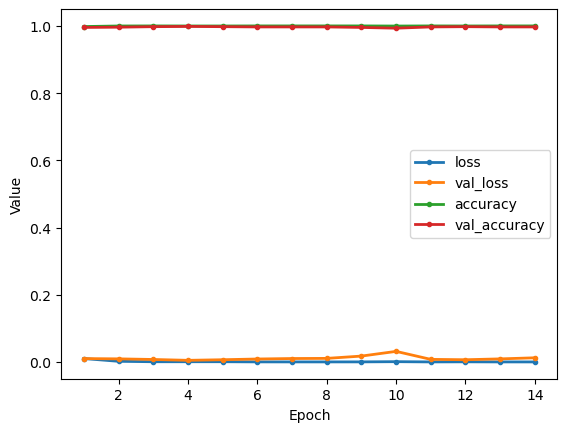

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/53 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step

 5/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

 9/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

13/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

17/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

22/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

27/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

31/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

35/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

39/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

43/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

51/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


 1/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step

 5/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

 9/53 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

14/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

18/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

22/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

26/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

30/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

34/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

38/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

43/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

47/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


In [26]:
report.save()

Report saved as Output/Reports/TCP/report_YNE9QDMQ.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################